In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the processed dataset
df = pd.read_csv('../../data/processed/processed_data_with_features.csv')

# Define features (X) and target (y)
X = df.drop(columns=['quantity'])  # Assuming `quantity` is the target variable
y = df['quantity']

# One-hot encode categorical columns
categorical_features = ['retailer', 'product']
X = pd.get_dummies(X, columns=categorical_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.07572932237782096
Mean Absolute Error (MAE): 0.2264304114819862
R-squared (R²): 0.46210284384776834


In [49]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Parameter grid
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost model
xgb = XGBRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=  13.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=  10.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=   9.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=   9.0s
[CV] EN

In [50]:
# Retrieve the best parameters from random search
best_params = random_search.best_params_

# Initialize and train the model with best parameters
xgb_best = XGBRegressor(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate
y_pred_best = xgb_best.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Mean Squared Error (MSE): {mse_best}")
print(f"Best Model - Mean Absolute Error (MAE): {mae_best}")
print(f"Best Model - R-squared (R²): {r2_best}")


Best Model - Mean Squared Error (MSE): 0.07559033424987889
Best Model - Mean Absolute Error (MAE): 0.22660651591460354
Best Model - R-squared (R²): 0.4630900614328666


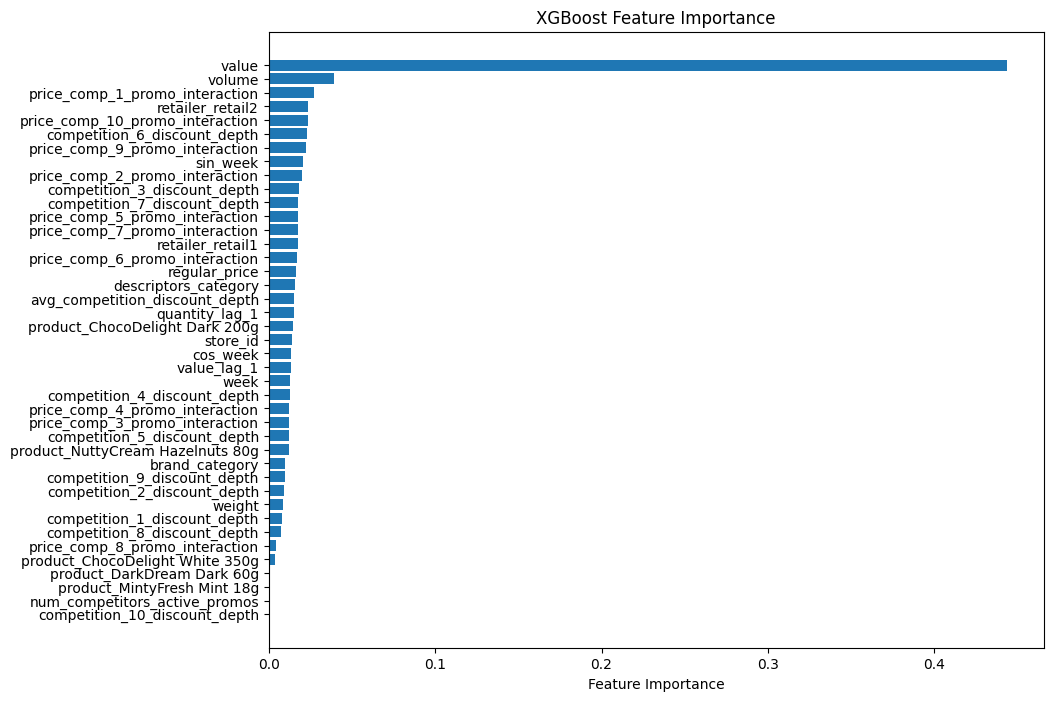

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
feature_importance = xgb_best.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

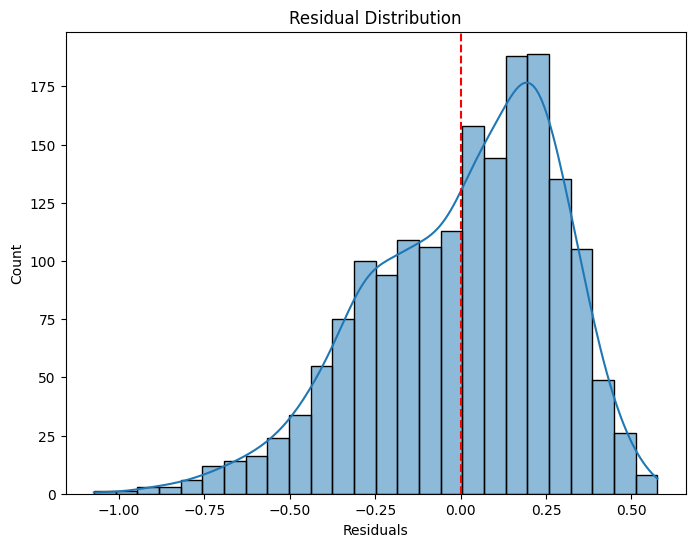

In [52]:
# Calculate residuals
residuals = y_test - y_pred_best

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

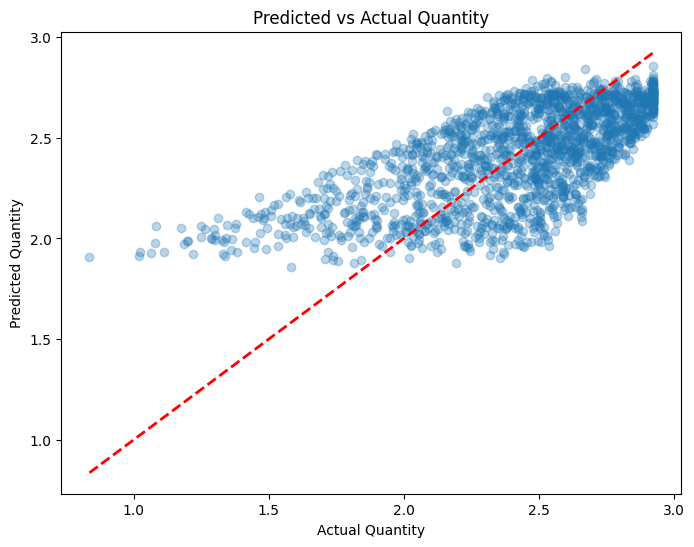

In [53]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Predicted vs Actual Quantity")
plt.show()


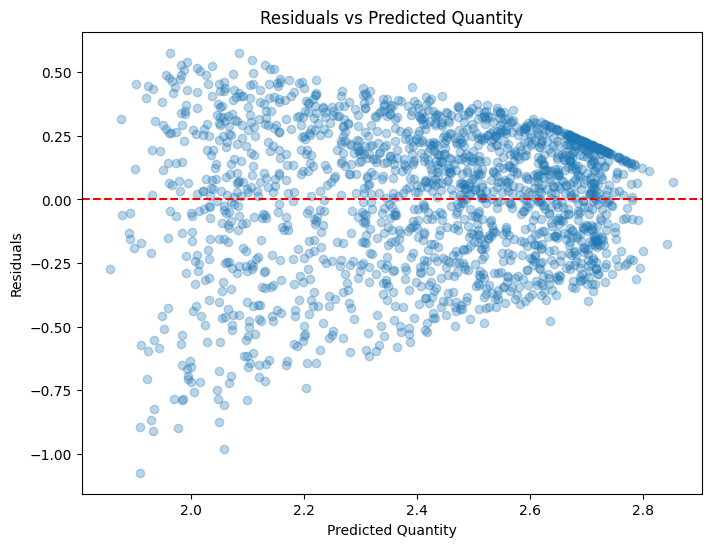

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_best, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Quantity")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Quantity")
plt.show()

In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Log Transformation of the Target Variable
df['log_quantity'] = np.log(df['quantity'] + 1)  # Adding 1 to avoid log(0) issues

# Define features (X) and the transformed target (y)
X = df.drop(columns=['quantity', 'log_quantity'])  # Remove original and log-transformed target from features
y = df['log_quantity']

# Step 2: Encode categorical features
X_encoded = pd.get_dummies(X, columns=['retailer', 'product'], drop_first=True)

# Train-Test Split with Validation Set
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Convert the data into XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Parameters for XGBoost including regularization
params = {
    "objective": "reg:squarederror",
    "alpha": 0.1,           # L1 regularization
    "lambda": 0.1,          # L2 regularization
    "learning_rate": 0.05,  # Reduced learning rate for fine-tuning
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

# Step 3: Train the model with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals,
                  early_stopping_rounds=50, verbose_eval=False)

# Make predictions on the validation set
y_pred_log = model.predict(dval)

# Convert predictions back to original scale
y_pred = np.exp(y_pred_log) - 1  # Reverse log transformation

# Step 4: Evaluate Model Performance
mse = mean_squared_error(np.exp(y_val) - 1, y_pred)  # Use original scale for comparison
mae = mean_absolute_error(np.exp(y_val) - 1, y_pred)
r2 = r2_score(np.exp(y_val) - 1, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")




Mean Squared Error (MSE): 0.07593950441706704
Mean Absolute Error (MAE): 0.22730854971913234
R-squared (R²): 0.4606099436390395
